# Model 5: Biased transmission (conformist bias)

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model5.html

### Note

色んなモデルが登場して、こんがらがってきたので、Model1〜5の位置付けを整理しておく。

- Transmission
    - Unbiased (Model 1)
    - Biased
        - Direct / content bias (Model 3): 直接 Trait が伝播しやすさに紐付いている。
        - Indirect bias (Model 4): Trait 以外の属性 (ペイオフ、年齢、ジェンダー、社会階層 など) が、伝播しやすさに紐付いている。
        - Conformist bias (Model 5): 多数派のTraitを真似する。
- Mutation (Model 2)
    - Unbiased
    - Biased

Model 5: Biased transmission (conformist bias)

- Conformity bias (or ‘positive frequency dependent bias’)
- Individuals are more likely to adopt the most common trait in the population.
- Model 1 とは異なり、人口比以上の強さで多数派に従う。
- この強さをパラメータ $D$ で表す ($0 \le D  \le 1$)。
- 集団からランダムに3つの個体を選び、以下の確率で trait $A$ をコピーする。
    - 3人とも$A$: $1.0$
    - 3人中2人が$A$: $\frac{2}{3} + \frac{D}{3}$
    - 3人中1人が$A$: $\frac{1}{3} - \frac{D}{3}$
    - 3人とも$B$: $0.0$

In [1]:
using DataFrames
using Statistics
using Plots
gr();

In [2]:
@enum Trait A B

# same as model 1
function make_agents_df(N::Int64, p_0::Float64)::DataFrame
    traits = [rand() < p_0 ? A : B for _ in 1:N]
    return DataFrame(trait = traits)
end

# same as model 1
function make_outputs_df(r_max::Int64, t_max::Int64)::DataFrame
    # r: trial number
    # t: generation number
    # p: proportion of individuals who possess trait A
    return DataFrame(
        r = fill(0, r_max * t_max),
        t = fill(0, r_max * t_max),
        p = fill(-1.0, r_max * t_max)
    )
end

# same as model 1
function calc_p(_agents_df::DataFrame)::Float64
    return nrow(_agents_df[_agents_df.trait.==A, :]) / nrow(_agents_df)
end

# same as model 1
function plot_outputs_df(outputs_df::DataFrame, title::String)::Plots.Plot
    p = plot(
        outputs_df[outputs_df.r.== 1, :].p,
        ylims = (-0.01, 1.01),
        title = title,
        xlabel = "generation",
        ylabel = "p, proportion of agents with trait A",
        legend = false
    )
    for r = 2:maximum(outputs_df.r)
        plot!(outputs_df[outputs_df.r.== r, :].p)
    end
    
    mean_df = combine(groupby(outputs_df, :t), :p => mean)
    plot!(mean_df.p_mean, lw = 4, lc = :black)

    return p
end

# new function
function get_new_trait(agents_df::DataFrame, D::Float64)::Trait
    demonstrators = rand(agents_df.trait, 3)
    A_count = count(demonstrators .== A)

    # 次のTraitがAになる確率
    prob = if A_count == 3
        1.0
    elseif A_count == 2
        2/3 + D/3
    elseif A_count == 1
        1/3 - D/3
    else
        0.0
    end

    return prob > rand() ? A : B
end

# modified based on model 1
function biased_transmission(N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, D::Float64)::DataFrame
    outputs_df = make_outputs_df(r_max, t_max)

    for r = 1:r_max
        agents_df = make_agents_df(N, p_0)

        for t = 1:t_max
            if t > 1
                # randomly copy from previous generation's agents
                agents_df = DataFrame(trait = [get_new_trait(agents_df, D) for _ in 1:N])
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            outputs_df.r[row_num] = r
            outputs_df.t[row_num] = t
            outputs_df.p[row_num] = calc_p(agents_df)
        end
    end
    
    return outputs_df
end

# modified based on model 1
function run(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, D::Float64)
    outputs_df = biased_transmission(N, r_max, t_max, p_0, D)
    plot_outputs_df(outputs_df, "N = $N, p_0 = $p_0, D = $D")
end;

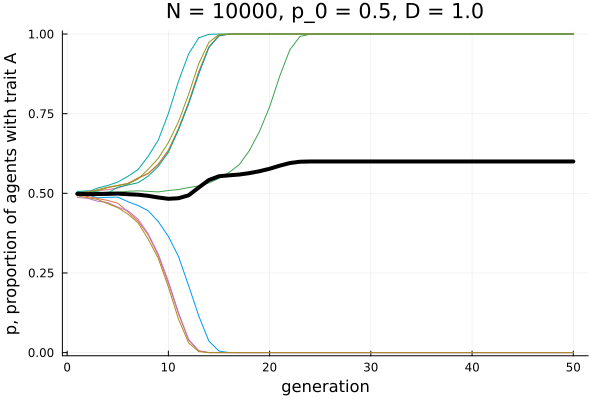

In [3]:
run(N = 10^4, r_max = 10, t_max = 50, p_0 = 0.5, D = 1.0)

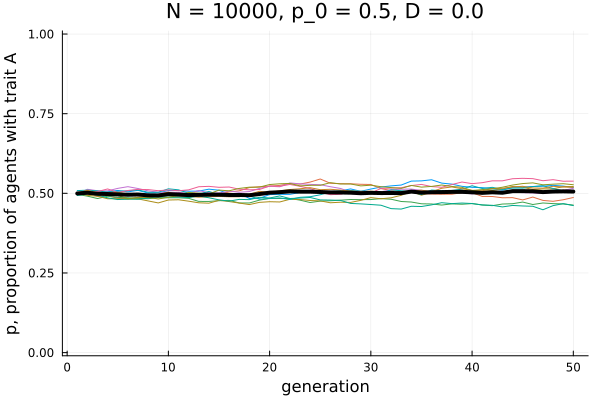

In [4]:
run(N = 10^4, r_max = 10, t_max = 50, p_0 = 0.5, D = 0.0)

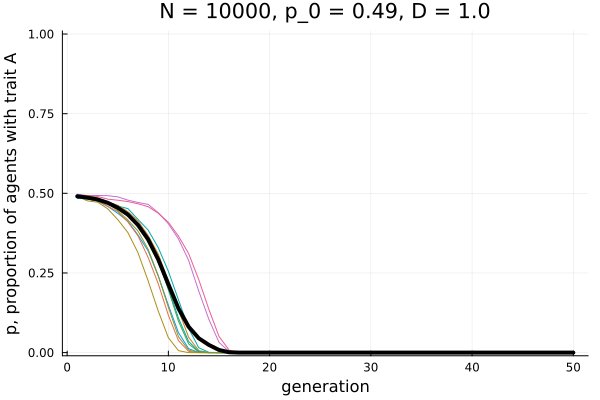

In [7]:
run(N = 10^4, r_max = 10, t_max = 50, p_0 = 0.49, D = 1.0)

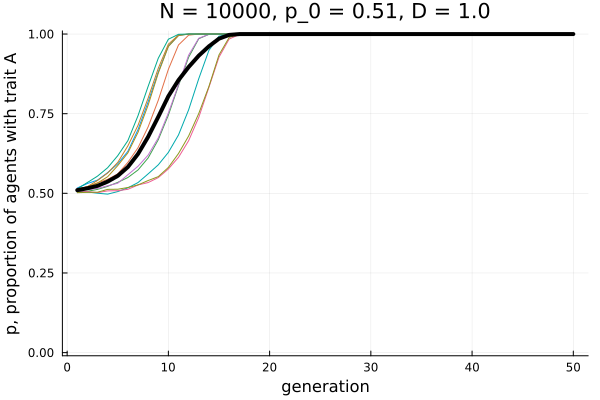

In [8]:
run(N = 10^4, r_max = 10, t_max = 50, p_0 = 0.51, D = 1.0)

### Note

- With conformity, the traits have no intrinsic attractiveness and are preferentially copied simply because they are common.
- Initial trait frequencies are important here: traits that are initially more common typically go to fixation.
- Experimental studies have shown that people exhibit conformity as defined and modelled here (Efferson et al. 2008; Muthukrishna et al. 2016; Deffner et al. 2020).
- Conformity is thought to have important implications for real-world patterns of cultural evolution by affecting the spread of novel innovations through societies (Henrich 2001), and by acting to maintain between-group cultural variation in the face of migration.